In [92]:
import heapq
import random

import networkx as nx
import numpy as np
from networkx.drawing.layout import bipartite_layout

# drawing graphs using matplotlib
from networkx.drawing.nx_pylab import draw_networkx
import logging

logger = logging.getLogger(__name__)
logger.setLevel(logging.ERROR)

In [93]:
def parse_nauty_edges(filename):
    """Parses an edge list file from nauty_gen into NetworkX graphs."""
    graphs = []

    with open(filename, "r") as file:
        for line in file:
            graph = nx.Graph()
            index, edges_str = line.strip().split(": ")
            edges = edges_str.split("; ")

            for edge in edges:
                nodes = tuple(map(int, edge.split(",")))
                graph.add_edge(*nodes)

            graphs.append(graph)

    return graphs


graph_list = parse_nauty_edges("file.txt")
print(len(graph_list))

11117


In [94]:
color_graphs = {}
for g in graph_list:
    colors = nx.coloring.greedy_color(g)
    num_colors = len(set(colors.values()))
    color_graphs[num_colors] = color_graphs.get(num_colors, []) + [g]

two_colorable = color_graphs.get(2, [])
print(len(two_colorable))

172


In [95]:
def construct_bipartite_graph(G_A_projected, num_B, max_degree_A=4, max_degree_B=2):
    random.seed(0)  # Ensure deterministic randomness

    # Define A and B sets
    num_A = len(G_A_projected.nodes())  # Number of A-nodes (SNAILs)
    A_nodes = list(G_A_projected.nodes())  # Keep integer labels for A-nodes
    B_nodes = list(range(1 + num_A, 1 + num_A + num_B))  # Ensures correct indexing

    # Initialize an empty bipartite graph G
    G_rebuilt = nx.Graph()
    G_rebuilt.add_nodes_from(A_nodes, bipartite=0)
    G_rebuilt.add_nodes_from(B_nodes, bipartite=1)

    # Track available B nodes per A-node
    available_B_nodes = {a: [] for a in A_nodes}
    degree_B = {b: 0 for b in B_nodes}  # Track degrees of B nodes
    degree_A = {a: 0 for a in A_nodes}  # Track degrees of A nodes

    # Edge stack: Track remaining edges to be satisfied
    edge_stack = set(G_A_projected.edges())

    # Step 1: Process edges from G_A using the greedy strategy
    while edge_stack:
        a1, a2 = edge_stack.pop()

        # Try to find an existing B-node that connects to a1 and does not create invalid edges
        best_b = None
        max_edges_removed = 0

        for b in available_B_nodes[a1]:
            if degree_B[b] < max_degree_B:
                # Check how many edges would be removed if we add (b, a2)
                edges_removed = {(a1, a2)} & edge_stack
                for a3 in G_rebuilt.neighbors(b):
                    if (a2, a3) in edge_stack:
                        edges_removed.add((a2, a3))

                # Only consider this b if it does not introduce unintended edges
                if all(
                    (a2, a3) in G_A_projected.edges()
                    for a3 in G_rebuilt.neighbors(b)
                    if a3 != a1
                ):
                    if len(edges_removed) > max_edges_removed:
                        max_edges_removed = len(edges_removed)
                        best_b = b

        if best_b:
            # Use the best B-node to remove the most edges from the stack
            G_rebuilt.add_edge(best_b, a2)
            degree_A[a2] += 1
            degree_B[best_b] += 1
            available_B_nodes[a2].append(best_b)
            edge_stack -= max_edges_removed  # Remove satisfied edges
            continue

        # No existing valid B-node, so we must create a new one
        b_candidates = [b for b in B_nodes if degree_B[b] < max_degree_B - 1]
        if not b_candidates:
            return None, None, None  # Stop if no available B nodes

        b = random.choice(b_candidates)  # Random but deterministic due to seed
        if degree_A[a1] == max_degree_A or degree_A[a2] == max_degree_A:
            return None, None, None  # Stop if constraint violation

        G_rebuilt.add_edge(a1, b)
        G_rebuilt.add_edge(b, a2)
        degree_A[a1] += 1
        degree_A[a2] += 1
        degree_B[b] += 2
        available_B_nodes[a1].append(b)
        available_B_nodes[a2].append(b)

    # # Step 2: Use priority queue to saturate under-connected A nodes
    # A_heap = [(degree_A[a], a) for a in A_nodes if degree_A[a] < max_degree_A]
    # heapq.heapify(A_heap)

    # for b in B_nodes:
    #     if degree_B[b] == 0:  # Find unused B-nodes
    #         while A_heap:
    #             _, a = heapq.heappop(A_heap)  # Get least connected A-node
    #             if degree_A[a] < max_degree_A:  # Only add if within constraints
    #                 G_rebuilt.add_edge(a, b)
    #                 degree_A[a] += 1
    #                 degree_B[b] += 1
    #                 available_B_nodes[a].append(b)
    #                 heapq.heappush(A_heap, (degree_A[a], a))  # Push updated degree back
    #                 break
    #         else:
    #             break  # No valid A-nodes left to use more B-nodes

    # Remove unused B-nodes from the graph
    connected_B_nodes = [b for b in B_nodes if degree_B[b] > 0]
    disconnected_B_nodes = set(B_nodes) - set(connected_B_nodes)
    G_rebuilt.remove_nodes_from(disconnected_B_nodes)

    # Print warning if not all B-nodes were used
    if disconnected_B_nodes:
        logger.warning(
            "Could only find a topology with {len(connected_B_nodes)} B-nodes instead of {num_B}."
        )

    # Step 3: Validate Degree Constraints
    violations_A = [a for a in A_nodes if degree_A[a] > max_degree_A]
    violations_B = [b for b in connected_B_nodes if degree_B[b] > max_degree_B]

    if violations_A or violations_B:
        return None, None, None  # Discard this topology

    return G_rebuilt, A_nodes, connected_B_nodes

In [110]:
total_valid = 0
for g in two_colorable:
    ret = construct_bipartite_graph(g, num_B=16, max_degree_A=4, max_degree_B=2)
    if ret[0] is not None:
        total_valid += 1
print(total_valid)

133


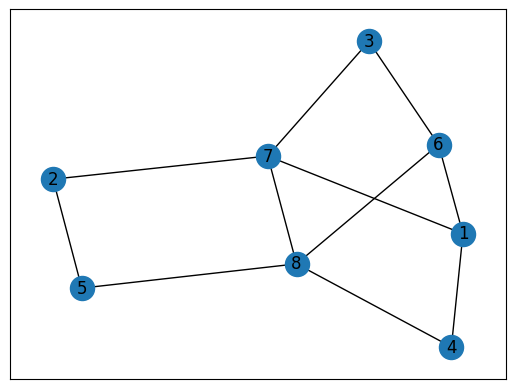

In [111]:
# Example Usage
# Parameters for the simpler prototype
num_A = 8  # Number of A-nodes
num_B = 16  # Number of B-nodes
max_degree_A = 4  # Each A-node can connect to at most 4 B-nodes
max_degree_B = 2  # Each B-node can connect to at most 2 A-nodes
index = -1  # Choose a two-colorable topology
G_A_projected = two_colorable[index]  # Take one of the two-colorable graphs
draw_networkx(G_A_projected)

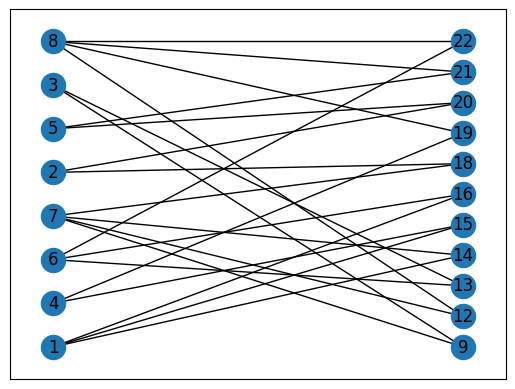

In [112]:
G_valid, A_nodes, B_nodes = construct_bipartite_graph(
    G_A_projected, num_B, max_degree_A=max_degree_A, max_degree_B=max_degree_B
)
if G_valid:
    pos = bipartite_layout(
        G_valid, [n for n in G_valid.nodes() if G_valid.nodes[n]["bipartite"] == 0]
    )
    draw_networkx(G_valid, pos)
else:
    print("No valid bipartite graph could be constructed.")

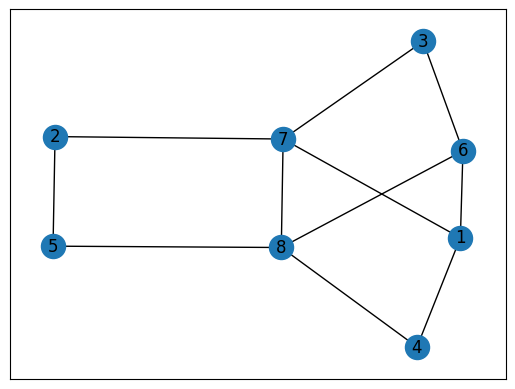

In [116]:
# construct G_A
G_A_projected = nx.bipartite.projected_graph(G_valid, A_nodes)
draw_networkx(G_A_projected)

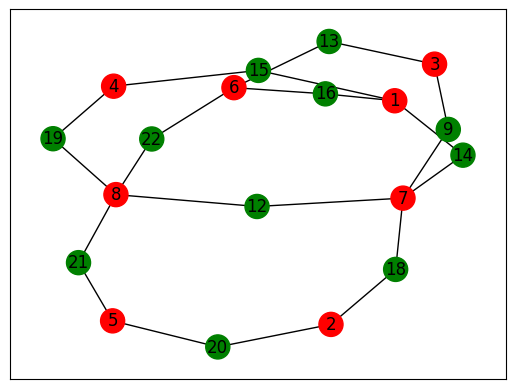

In [117]:
# draw_networkx(G_rebuilt)
# draw nodes from A red and nodes from B green
color_map = []
for node in G_valid:
    if node in A_nodes:
        color_map.append("red")
    else:
        color_map.append("green")
draw_networkx(G_valid, node_color=color_map, with_labels=True)

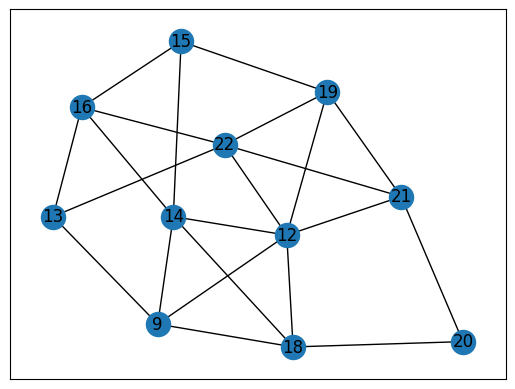

In [118]:
# construct G_B
G_B_projected = nx.bipartite.projected_graph(G_valid, B_nodes)
draw_networkx(G_B_projected)